# Investment Analysis - Final Project
### Author: Štěpán Pardubický
This python notebook contains sollution for Investment Analysis assignment.
 - To run the notebook, it is required to install the nescessary libraries (see README.md and requirements.txt), prefferably in the form of python virtual enviroment.
 - Most of the utilized functions are implemented in local functions module (functions folder in this repo).
 - Alternatively one can view the streamlit application developed for the project (see the README.md for the process)

## Task description
*Assume, that you are a consultant of an investor on NASDAQ stock exchange, whose initial capital is
100 000 USD. He is allowed to invest into the following eight stocks – (see enclosed paper with list of
stocks) and potentially into the risk-free asset, one-month treasury bond of the US government. The
investor is asking for an advice how to invest his capital.*


## Part 0: Imports and constants declaration

In [69]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Custom created functions
from functions.data_manipulation_functions import load_and_transform_raw_data_full, select_relevant_cols

from functions.data_exploration_functions import (
    get_missing_and_zero_values,
    plot_df,
    get_descriptive_statistics,
    barplot_means,
    plot_covariances_matrix,
    plot_autocorrelation,
    plot_weights_bar,
)

from functions.portfolio_functions import (
    efficient_frontier_complete,
    efficient_frontier_complete_riskless,
    portfolio_std,
    compute_markowitz_weights,
    compute_max_sharpe_weights,
    compute_equal_weights_portfolio,
)

from functions.portfolio_eval_functions import (
    multiple_daily_reinvesting_strategy,
    convert_multiple_reinvestment_output_to_df,
    plot_multiple_reinvestment_results,
)

In [57]:
from config.constants_config import BASE_TICKER_SET, BASE_START_DATE, BASE_TODAY_DATE, BASE_END_DATE
BASE_TICKER_SET = sorted(BASE_TICKER_SET)
num_days_year = 252
initial_investment = 100000 # 100k USD
BASE_START_TRADE_DATE = "2022-10-25"
BASE_END_TRADE_DATE = "2024-10-24"

comp_returns_col_regexp = r"_interdaily_pct_change_log$"
physical_returns_col_regexp = r"_interdaily_pct_change$"

In [56]:
BASE_END_DATE

'2024-10-25'

## Part 1: Data
*Retrieve data of daily returns of the individual assets. These can be downloaded for example
at https://finance.yahoo.com. (fill in the company ticker, go to the tab historical data and
select time period 1.1.2021 – 25.10.2024). Daily returns are calculated as the logarithm of a
ratio of Close and Open price. If data of one of your stocks do not cover the entire period,
pick the next one in alphabetical order instead.
Data about the annual risk-free return can be downloaded at
http://www.karlin.mff.cuni.cz/~rusy/AnalyzaInvestic/USYields2024.csv.
Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time?*

In [3]:
print(f"We are working with the following tickers: {BASE_TICKER_SET}")
print(f"We are working with the following dates: {BASE_START_DATE} to {BASE_END_DATE}")
print(f"The current date is: {BASE_TODAY_DATE}")

We are working with the following tickers: ['ADSK', 'ANSS', 'COST', 'EXC', 'PCAR', 'SIRI', 'TXN', 'ZS']
We are working with the following dates: 2021-01-01 to 2024-10-25
The current date is: 2022-10-24


#### Several notes
 - We choose to work with daily returns (ie. reported means, stds, variances are for the daily forms)
 - Given that we compute gains only as (log) ratios of daily returns (ratio of close to open stock price), we effectively do not hold stock between days and on non-trading days. Given that the open price doesn't equal close price of previous day, this limits our ability to utilize the positive drift in stock prices to the full potential
 - Additionally we choose to calculate the daily riskless yields by assuming 252 days in a year. This assumption may be arbitrary - more thought process should be put into how portfolio is managed on the off-time (Do we hold only cash during the non-trade days, then it would be probably better to assume the full 365 day years)

In [4]:
# Download stock data from Yahoo Finance, load bond yields, transform into single dataset
comb_df = load_and_transform_raw_data_full(BASE_TICKER_SET, BASE_START_DATE, BASE_END_DATE, num_days_year = num_days_year)

[*********************100%***********************]  8 of 8 completed


In [5]:
comb_df_train = comb_df.loc[comb_df.index < BASE_TODAY_DATE]
comb_df_trade = comb_df.loc[comb_df.index >= BASE_TODAY_DATE]

print(f"We are worjing with {comb_df_train.shape[0]} training data points and {comb_df_trade.shape[0]} trading data points")

We are worjing with 455 training data points and 504 trading data points


For data exploration part we utilize all the data, note that not all data can then be used for training

##### Missing and zero values

In [6]:
# No missing (null) values found, some zero values present in the dataset (indicate no difference between open and close price)
get_missing_and_zero_values(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = comp_returns_col_regexp)

Following missing values were found:
Missing values: Series([], dtype: int64)
Following zero values were found:
Zero values: ADSK_interdaily_pct_change_log     1
ANSS_interdaily_pct_change_log     3
COST_interdaily_pct_change_log     2
EXC_interdaily_pct_change_log     13
PCAR_interdaily_pct_change_log     4
SIRI_interdaily_pct_change_log    35
ZS_interdaily_pct_change_log       1
dtype: int64


##### Price evolution

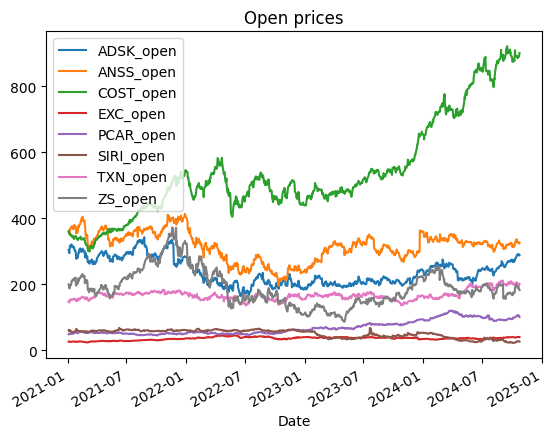

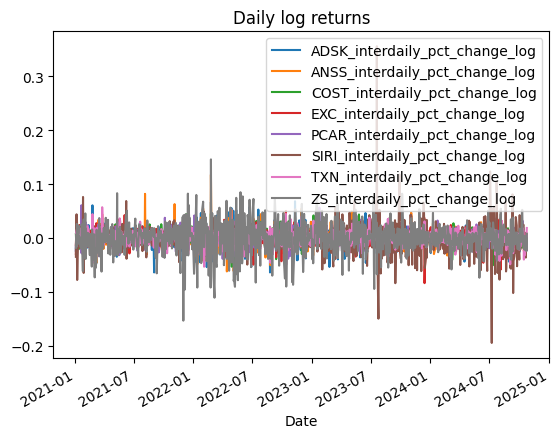

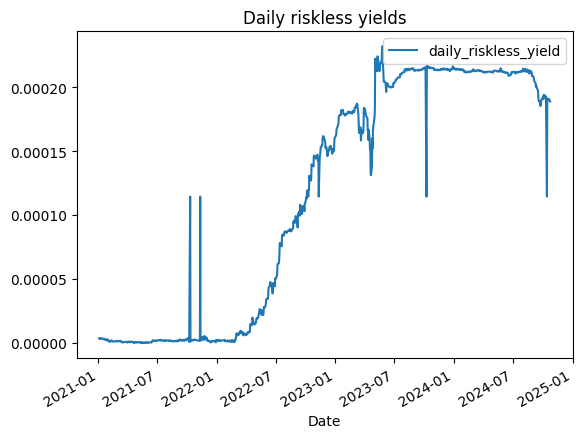

In [7]:
plot_df(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = r"open$", title = "Open prices")
plot_df(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = comp_returns_col_regexp, title = "Daily log returns")
plot_df(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = "riskless", title = "Daily riskless yields")

##### Basic descriptive statistics

In [8]:
## Descriptive statistics for the dataset - not very transparent

# Set print sttas to True to print out the statistics
print_stats = False
full_mean, full_var, full_cov, full_corr =  get_descriptive_statistics(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = comp_returns_col_regexp, print_stats = print_stats) 

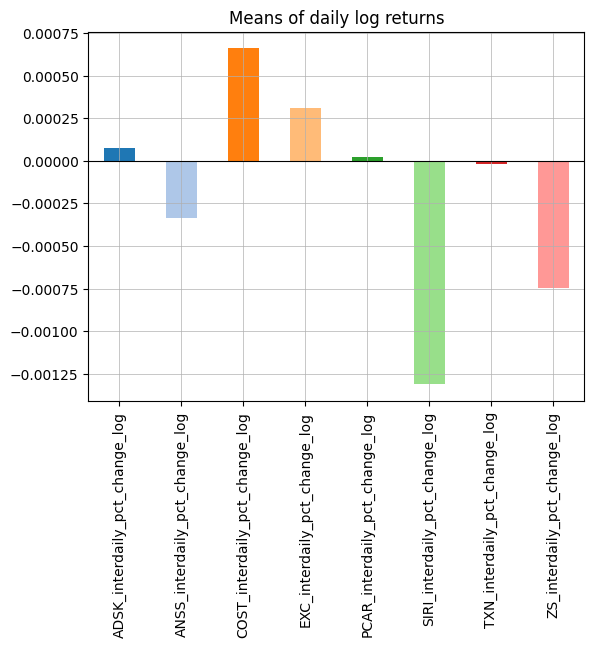

In [9]:
barplot_means(full_mean, title = "Means of daily log returns", rotatex=False) # Some of the chosen stocks seem to have quite a poor performance over the chosen period

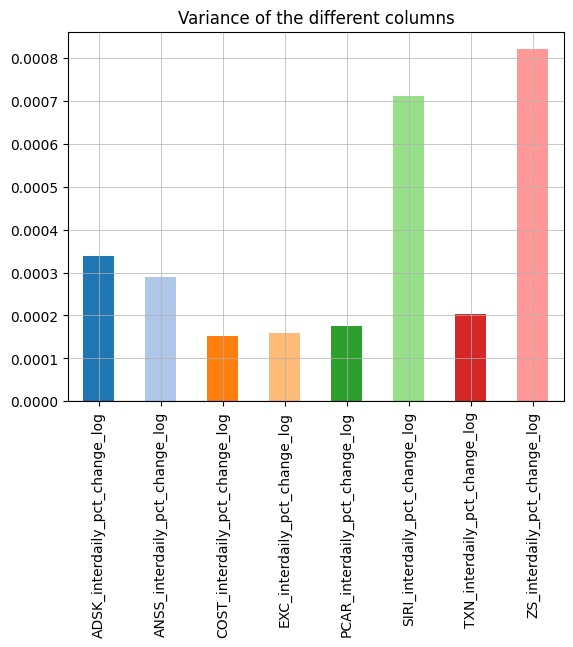

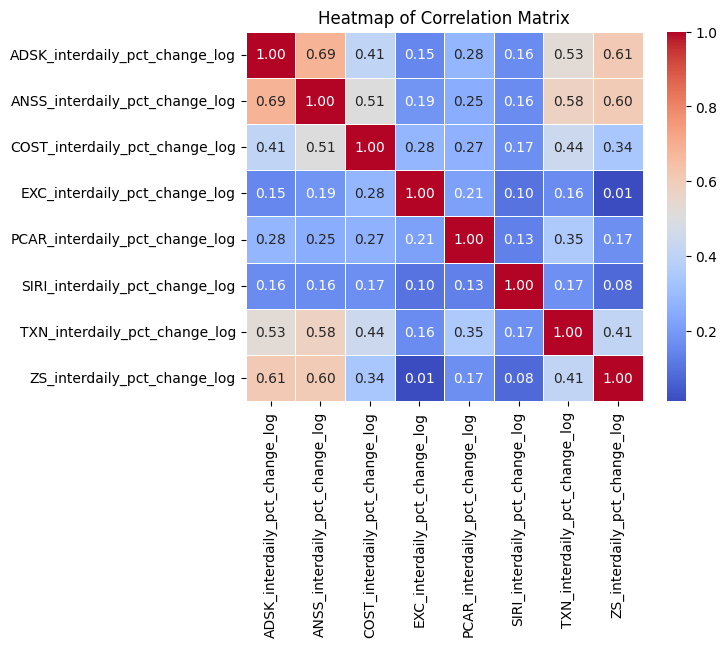

In [10]:
plot_covariances_matrix(full_var, full_corr) # All of the chosen stocks are either positively correlated or uncorrelated (This result is not very surprising)

##### Autocorrelation

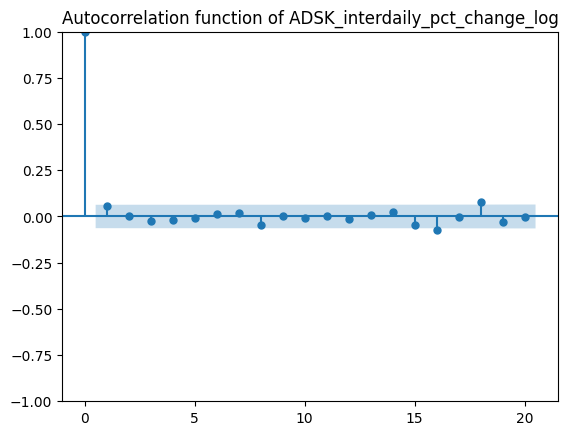

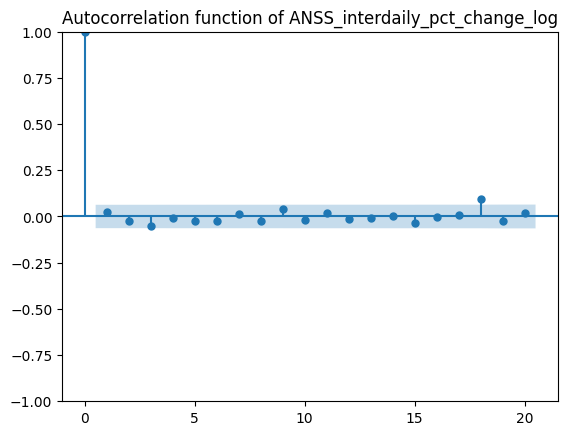

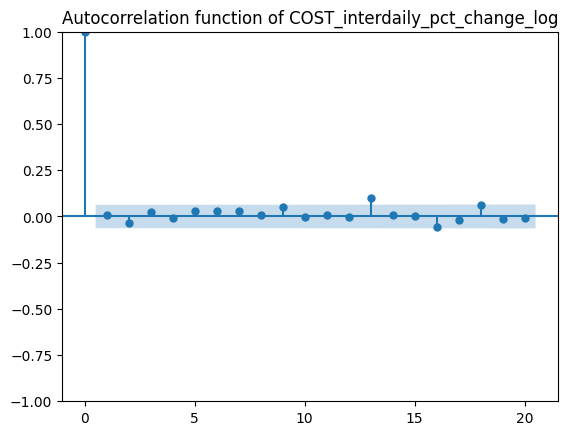

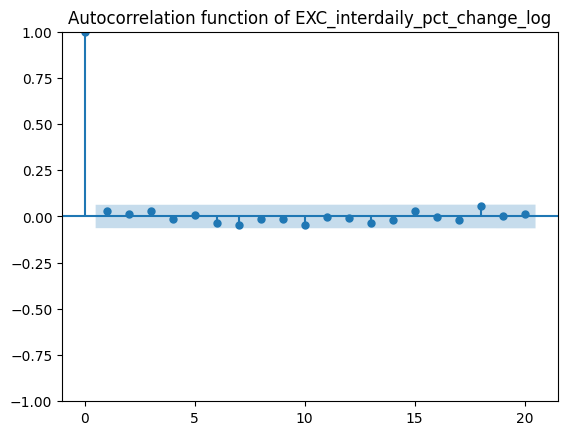

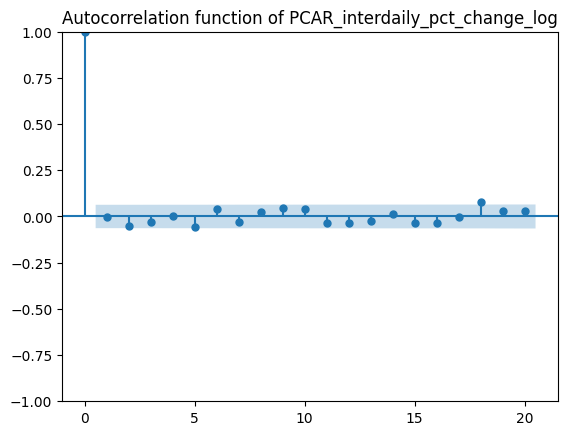

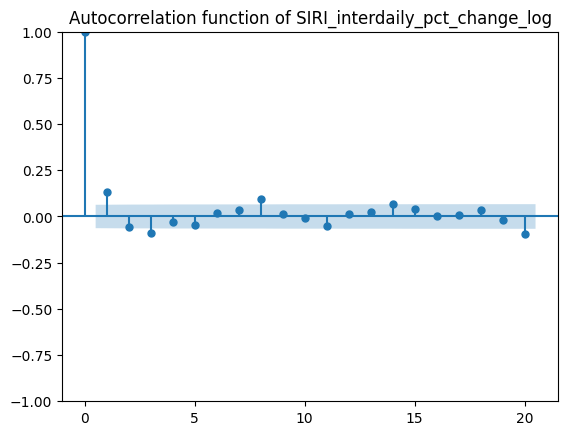

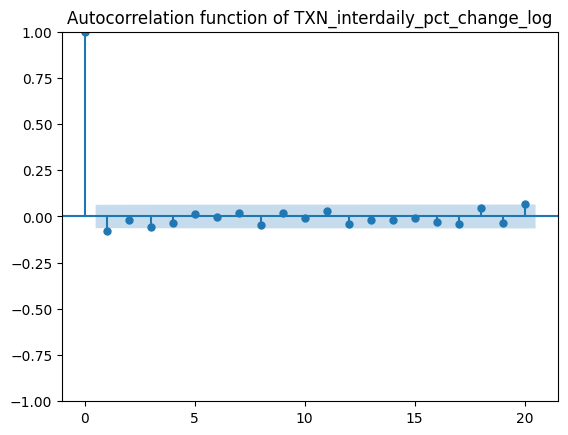

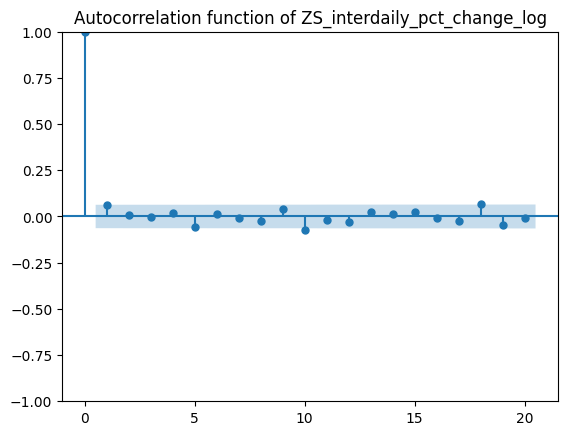

In [11]:
# The autocorrelation of the daily log returns for all selected stocks and all lags is relatively low
plot_autocorrelation(comb_df, start_date=BASE_START_DATE, end_date=BASE_END_DATE, col_regexp_substring = comp_returns_col_regexp, title = "Autocorrelation of daily log returns", lags = 20) 

##### Do the descriptive statistics (mean, variance) change over time
Given the relatively large variances, we can expect the rolling statistics to vary. We are however interested in whether we could observe a clear trend.  
We utilize rolling windows.

In [12]:
rolling_window_size = 30

comb_df_returns = select_relevant_cols(comb_df, col_regexp_substring=comp_returns_col_regexp)

# Rolling window mean and variance of the daily log returns
rolling_mean = comb_df_returns.rolling(window=rolling_window_size).mean()
rolling_var = comb_df_returns.rolling(window=rolling_window_size).var()

rolling_auto_corr = comb_df_returns.rolling(window=rolling_window_size).apply(lambda x: x.autocorr(lag=1))


No clear drift can be observed, but there seem to be periods of enlarged volatility (at least for some stocks (SIRI,ZS))
No clear picture can be drawn from the rolling autocorrelation (There seem to be almost none autocorrelation among the individual returns)

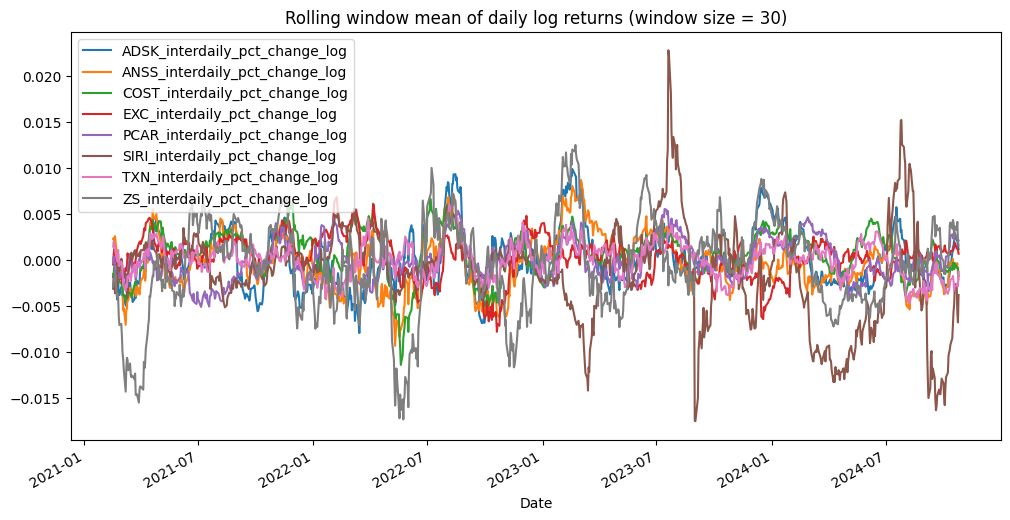

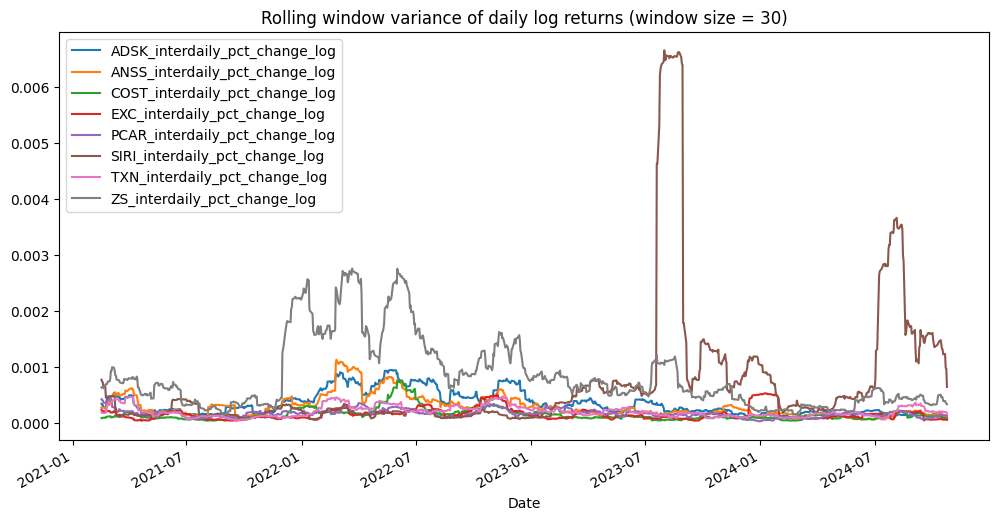

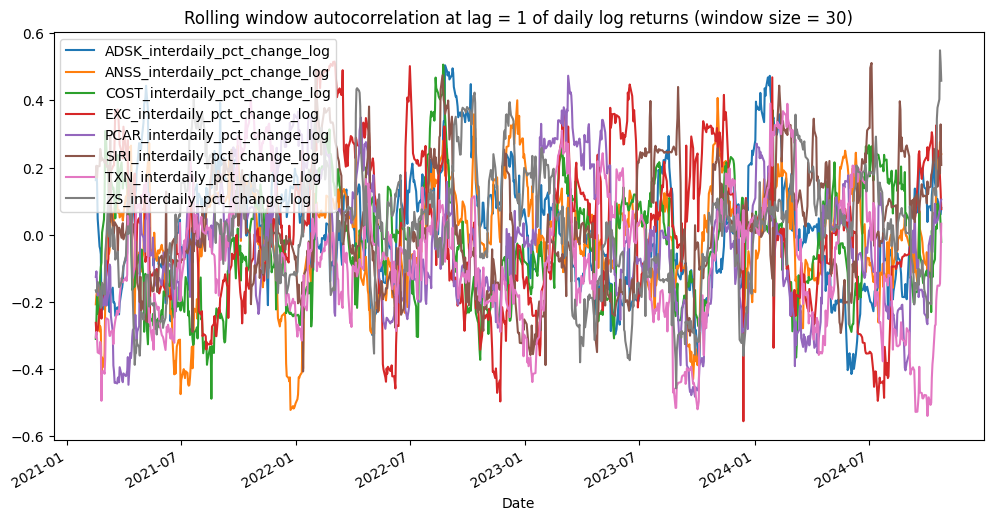

In [13]:
original_figsize = plt.rcParams["figure.figsize"]

plt.rcParams["figure.figsize"] = [12,6]
rolling_mean.plot(title = f"Rolling window mean of daily log returns (window size = {rolling_window_size})")
plt.legend(loc = "upper left")
plt.show()

rolling_var.plot(title = f"Rolling window variance of daily log returns (window size = {rolling_window_size})")
plt.legend(loc = "upper left")
plt.show()

rolling_auto_corr.plot(title = f"Rolling window autocorrelation at lag = 1 of daily log returns (window size = {rolling_window_size})")
plt.legend(loc = "upper left")
plt.show()

plt.rcParams["figure.figsize"] = original_figsize

## Part 2 - Efficient Portfolios
*Assume that today is 24.10.2022, after the end of the business day (so all data till 24.10.2022
are observed). Estimate the set of efficient portfolios without the risk-free asset. Show
graphically.
Calculate and plot also the Capital Market Line, this time with the use of the risk-free asset.
What is the composition of the tangency portfolio?
Plot the Security Market Line, estimate where your stocks lie on this chart.*

In [14]:
## Compute descriptive statistics up to the current date
train_mean, train_var, train_cov, train_corr =  get_descriptive_statistics(comb_df_train, start_date=BASE_START_DATE, end_date=BASE_TODAY_DATE, col_regexp_substring = comp_returns_col_regexp, print_stats = False)

##### Efficient frontier without riskless asset

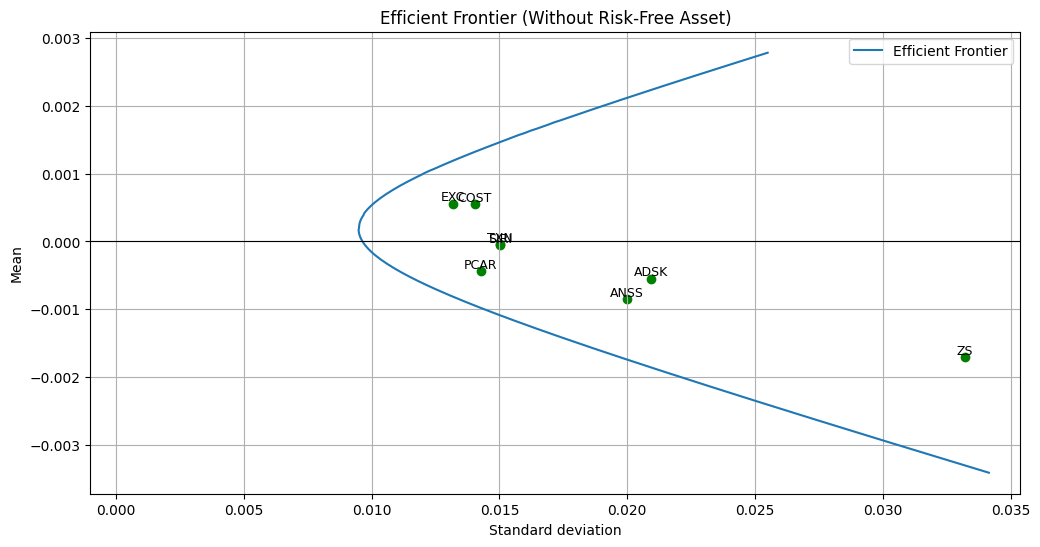

In [15]:
## Estimate the set of efficient porfolios withour risk-free asset
## Utilize python optimization package scipy.optimize to find the optimal portfolios

plt.rcParams["figure.figsize"] = [12,6]

efficient_portfolios_result = efficient_frontier_complete(
    means=train_mean,
    covs=train_cov,
    var = train_var,
    plot_results=True,
    positive_weights_bound = False, # Allow for short selling
    plot_individual_stocks = True,
    min_func = portfolio_std,
    means_max_coef = 5,
    means_min_coef = 2,
    num_points = 200,

)
plt.show()


##### Tangent portfolio, Capital market line

The current riskless yield is 0.0001392062224645496


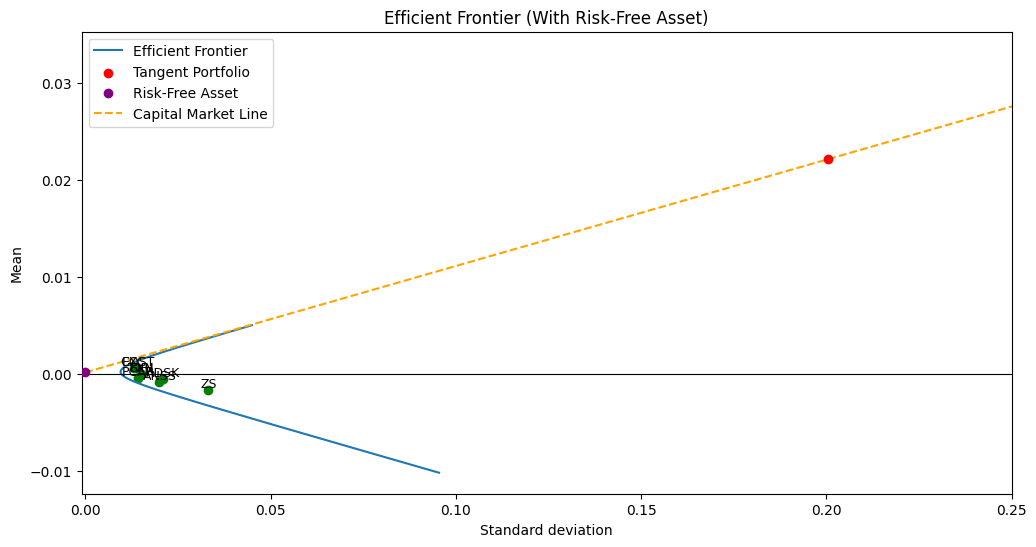

In [16]:
## The capital market line and tangent portfolio both depend on the current riskless yield - will vary with the daily riskless yields
today_riskless_yield = comb_df_trade["daily_riskless_yield"].loc[BASE_TODAY_DATE]
print(f"The current riskless yield is {today_riskless_yield}")


weights_tangent, mean_tangent, std_tangent = efficient_frontier_complete_riskless(
    means = train_mean,
    covs = train_cov,
    var = train_var,
    riskless_rate = today_riskless_yield,
    plot_individual_stocks = True,
    mean_tangent_mul = 10,
    means_max_coef = 30,
    right_x_lim = 0.25,
)
plt.show()


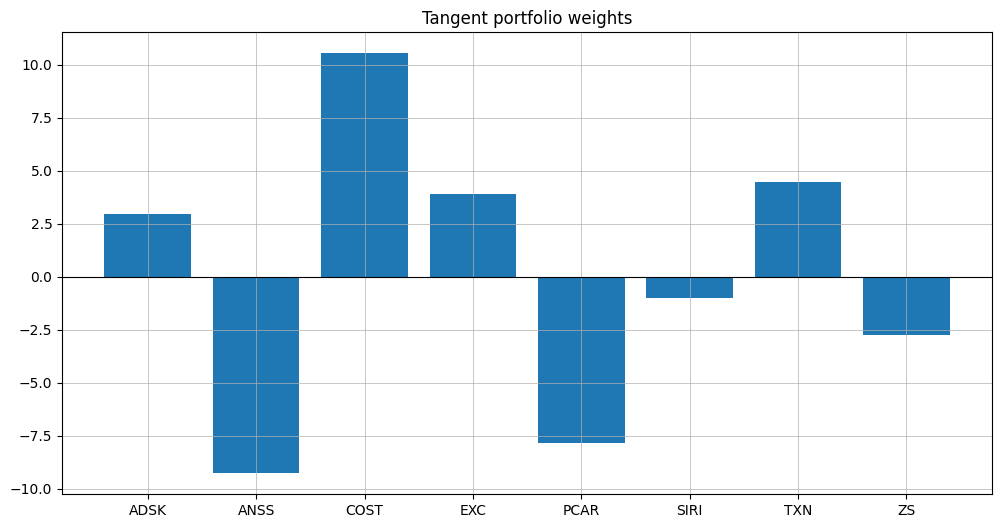

The mean of the tangent portfolio is 0.02213896012996843 and the standard deviation is 0.20037200199129557


In [17]:
##We see that the results of tangent are quite extreme (such a strong leverage is not realistic)
plot_weights_bar(weights_tangent,tickers=BASE_TICKER_SET,title = "Tangent portfolio weights")
print(f"The mean of the tangent portfolio is {mean_tangent} and the standard deviation is {std_tangent}")

##### Security Market Line

In [19]:
#TODO: Compute the security market line

## Part 3: The Markowitz Model
*Choose a business strategy based on the Markowitz model, either with aim to maximize
expected return when conditioning on risk, or to minimize risk subject to some minimum
expected return.
Define parameters of your strategy (maximum risk/minimum return), so these parameters
are realistic (they can be also set based on current market behavior)
Define a way how other inputs for the model (expected asset return and their covariances)
will be estimated.*

**The chosen Markowritz Strategy**
 - Minimize risk (std) conditioning on minimal expected returns
 - Since we have no info about some "fundamental shifts" in the market (would be hard to estimate), we choose a simple strategy for estimating expected returns and covariances
    - Every trading day we compute expected return as sample mean of returns up to that point.
    - Simmilarly with sample covariance
    - Statistics need to be recalculated daily, only taking into account results occuring in the past
    - There are probably "cleverer" ways to compute the statistics (exponentially decaying weighted averages, ...)
 - We choose expected return as a fixed fraction of the maximum observed mean returns among utilized stocks
    - Given the large volatility and presence of negative returns among our observed stocks, we will stick to "conservative" portfolios (fraction < 1) 

In [47]:
required_max_percentage =0.95
required_return = train_mean.max()*required_max_percentage

In [48]:
share_weights, riskless_asset_weight = compute_markowitz_weights(
    means = train_mean,
    covs = train_cov,
    riskless_rate=today_riskless_yield,
    required_return = required_return,
)

# plot_weights_bar(np.concatenate(share_weights,tickers=BASE_TICKER_SET,title = "Share portfolio weights")

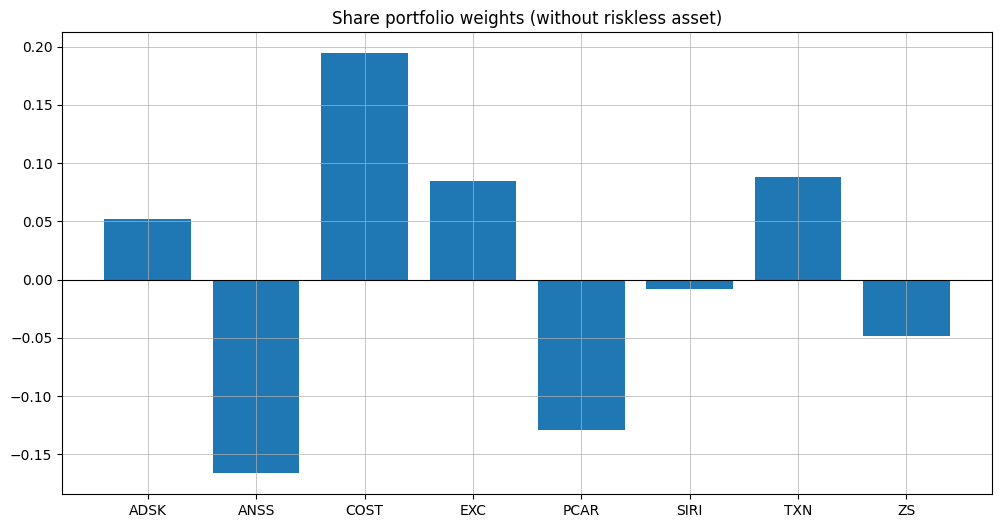

In [49]:
plot_weights_bar(share_weights,tickers=BASE_TICKER_SET,title = "Share portfolio weights (without riskless asset)")

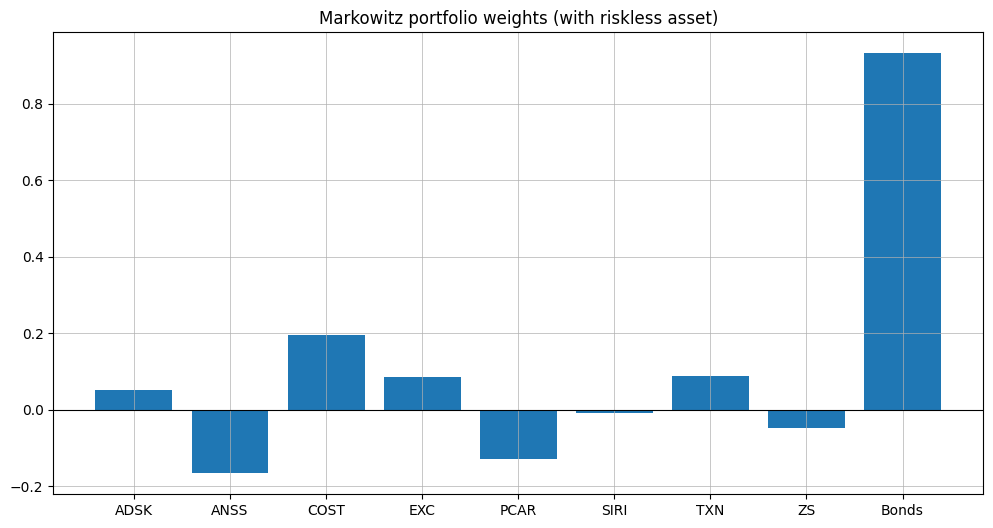

In [50]:
plot_weights_bar(np.append(share_weights, riskless_asset_weight),tickers=BASE_TICKER_SET +["Bonds"],title = "Markowitz portfolio weights (with riskless asset)")

## Part 4: Out-of-Sample Investment
*Implement the proposed strategy, with the first investment on 25.10.2022 and the final one
on 24.10.2024. Every day, evaluate your investment based on the most recent market
movements and calculate the new optimal portfolio and invest according to it. Be careful,
that into the decision, how to invest the next day, only the data observed till the previous
date are used.
Describe the results of this exercise, comment on the return of the strategy and how it
corresponds to the assumed return and your expectations (strategy definition and parameter
selection). Compare, how your strategy performs against the average portfolio (all stock in
portfolio have equal weight) and against the fixed tangency portfolio as found in 2).*

In [60]:
## Perform Markowitz reinvestment strategy
markowitz_results = multiple_daily_reinvesting_strategy(
    initial_portfolio_value=initial_investment,
    full_data=comb_df,
    start_est_date=BASE_START_DATE,
    start_trade_date=BASE_START_TRADE_DATE,
    end_trade_date = BASE_END_TRADE_DATE,
    wieghts_recalculation_style="daily",
    calc_share_returns_regexp=comp_returns_col_regexp,
    physical_share_returns_regexp=physical_returns_col_regexp,
    riskfree_rate_col="daily_riskless_yield",
    weights_computation_function=compute_markowitz_weights,
    weight_computation_kwargs={"required_return": required_return},
)
(mark_daily_portfolio_values, 
 mark_daily_portfolio_share_weights, 
 mark_daily_portfolio_riskfree_weights, 
 mark_realized_trade_dates) = markowitz_results

In [66]:
## NOTE: Is the tangent portfolio supposed to be fixed or should it's weights be fixed?
## Perform Tangent reinvestment strategy
tangent_results = multiple_daily_reinvesting_strategy(
    initial_portfolio_value=initial_investment,
    full_data=comb_df,
    start_est_date=BASE_START_DATE,
    start_trade_date=BASE_START_TRADE_DATE,
    end_trade_date = BASE_END_TRADE_DATE,
    wieghts_recalculation_style="fixed_weights", # Or alternatively "fixed_portfolio"
    calc_share_returns_regexp=comp_returns_col_regexp,
    physical_share_returns_regexp=physical_returns_col_regexp,
    riskfree_rate_col="daily_riskless_yield",
    weights_computation_function=compute_max_sharpe_weights,
)

(tangent_daily_portfolio_values, 
 tangent_daily_portfolio_share_weights, 
 tangent_daily_portfolio_riskfree_weights, 
 tangent_realized_trade_dates) = tangent_results

In [68]:
equal_results = multiple_daily_reinvesting_strategy(
    initial_portfolio_value=initial_investment,
    full_data=comb_df,
    start_est_date=BASE_START_DATE,
    start_trade_date=BASE_START_TRADE_DATE,
    end_trade_date = BASE_END_TRADE_DATE,
    wieghts_recalculation_style="daily", #The choice here doesnt matter unless we chose fixed portfolio
    calc_share_returns_regexp=comp_returns_col_regexp,
    physical_share_returns_regexp=physical_returns_col_regexp,
    riskfree_rate_col="daily_riskless_yield",
    weights_computation_function=compute_equal_weights_portfolio,
)

(
    equal_daily_portfolio_values, 
    equal_daily_portfolio_share_weights, 
    equal_daily_portfolio_riskfree_weights, 
    equal_realized_trade_dates
) = equal_results

In [71]:
markowitz_df = convert_multiple_reinvestment_output_to_df(*markowitz_results, tickers=BASE_TICKER_SET)
tangent_df = convert_multiple_reinvestment_output_to_df(*tangent_results, tickers=BASE_TICKER_SET)
equal_df = convert_multiple_reinvestment_output_to_df(*equal_results, tickers=BASE_TICKER_SET)

##### Plot Markowitz portfolio evolution

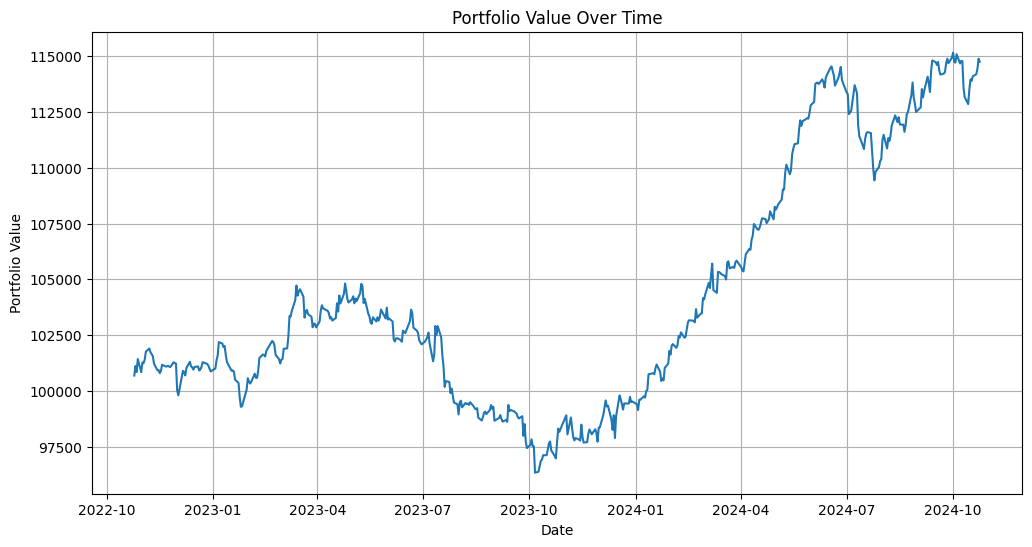

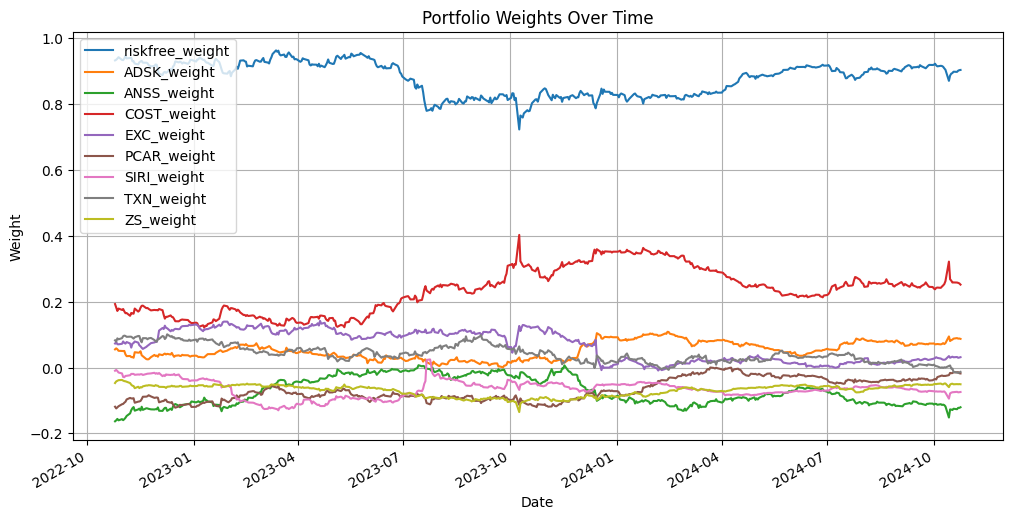

In [73]:
plot_multiple_reinvestment_results(
    output_df=markowitz_df,
    plot_portfolio_value=True,
    plot_weights=True,
    show_plots=True,
)

##### Plot tangent portfolio evolution

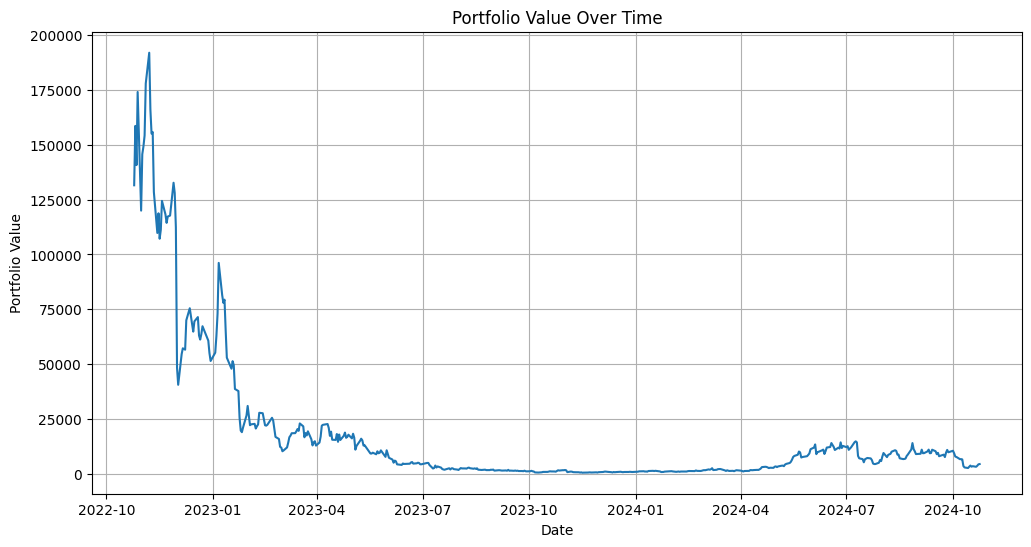

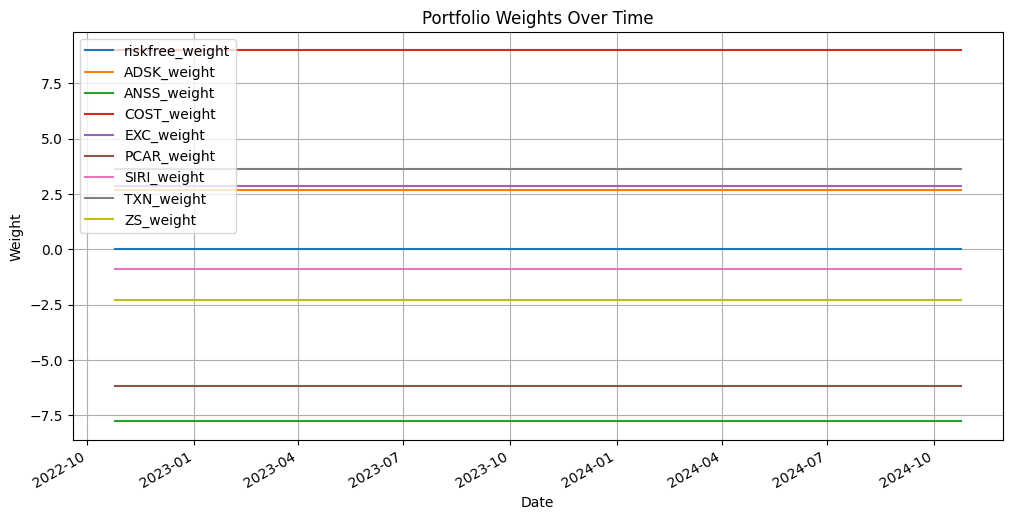

In [74]:
plot_multiple_reinvestment_results(
    output_df=tangent_df,
    plot_portfolio_value=True,
    plot_weights=True,
    show_plots=True,
)

##### Plot equal weights result

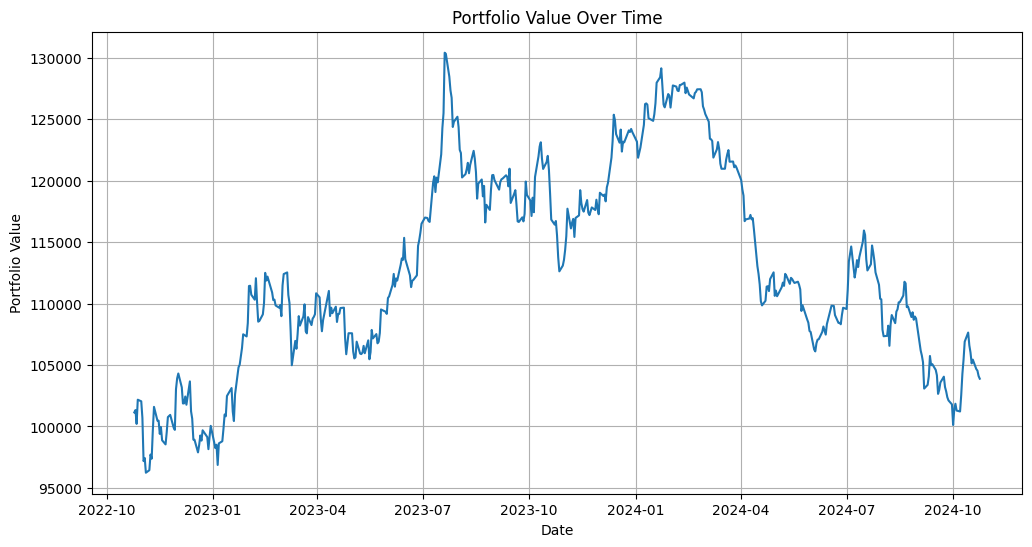

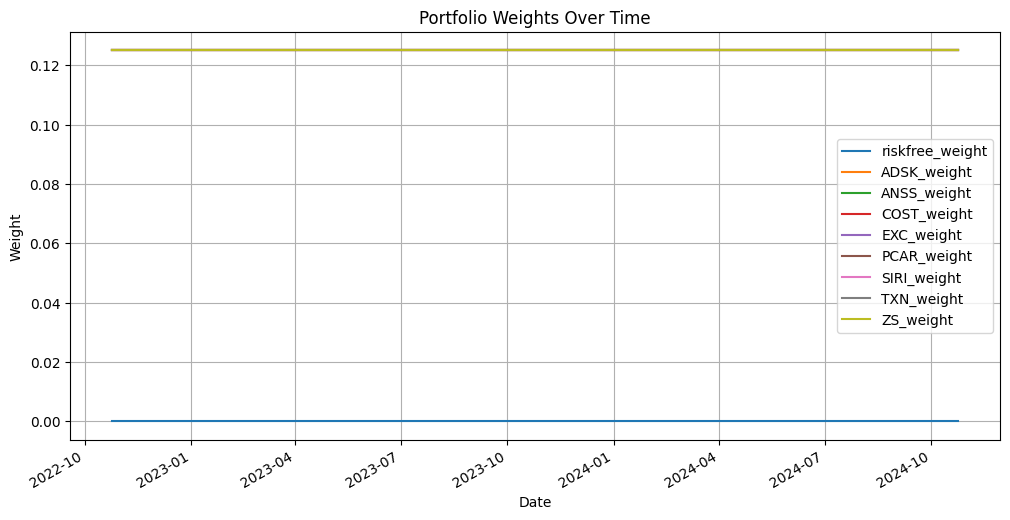

In [75]:
plot_multiple_reinvestment_results(
    output_df=equal_df,
    plot_portfolio_value=True,
    plot_weights=True,
    show_plots=True,
)

In [80]:
print(f"There were in total {len(mark_realized_trade_dates)} trading days during our investment period")
print(f"The Markowitz strategy yielded a total of {mark_daily_portfolio_values[-1]:.2f} USD")
print(f"The value of the Markowitz portfolio is {mark_daily_portfolio_values[-1]/initial_investment:.2%} of the initial one")
print(f"The Tangent strategy yielded a total of {tangent_daily_portfolio_values[-1]:.2f} USD")
print(f"The value of the Tangent portfolio is {tangent_daily_portfolio_values[-1]/initial_investment:.2%} of the initial one")
print(f"The Equal strategy yielded a total of {equal_daily_portfolio_values[-1]:.2f} USD")
print(f"The value of the Equal portfolio is {equal_daily_portfolio_values[-1]/initial_investment:.2%} of the initial one")

There were in total 503 trading days during our investment period
The Markowitz strategy yielded a total of 114753.44 USD
The value of the Markowitz portfolio is 114.75% of the initial one
The Tangent strategy yielded a total of 4399.56 USD
The value of the Tangent portfolio is 4.40% of the initial one
The Equal strategy yielded a total of 103886.71 USD
The value of the Equal portfolio is 103.89% of the initial one


In [83]:
(1 + required_return)**(len(mark_realized_trade_dates))

1.3042723629698787